In [1]:
!pip install spuco torch torchvision scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 15.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.3 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=59f0109904e62e2b87e20e3a084cc35e78c5d101781910e271bcfccb114c0e4a
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
from torchvision import transforms

# SpuCo imports
from spuco.datasets import SpuCoMNIST, SpuriousFeatureDifficulty
from spuco.utils import set_seed

set_seed(12345) # Just to get reproducible results everytime like in the hw

In [ ]:
from spuco.models import model_factory
from spuco.utils import Trainer
from torch.optim import Adam
from torch.optim import SGD
import torch.nn.functional as F

# This is the "dumb" agent that picks up on spurious features quick, if my hypotehsis is correct.
class FullModel(nn.Module):
    def __init__(self, num_classes=5):
        super(SmallBiasedModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Flatten: 32 channels * 7 * 7 spatial dim
        self.fc_input_dim = 32 * 7 * 7

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.fc_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        logits = self.classifier(x)
        return logits


# This one has an 8x8 input, specifically for MNIST because the images are tiny there.
class SmallBiasedMNISTModel(nn.Module):
    def __init__(self, num_classes=5):
        super(SmallBiasedMNISTModel, self).__init__()
        self.features = nn.Sequential(
            # Input: 3 x 8 x 8
    
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_input_dim = 32 * 2 * 2

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.fc_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        logits = self.classifier(x)
        return logits

class SmallerBiasedMNISTModel(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        # Input: 3 x 4 x 4
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)

        self.fc = nn.Linear(16 * 4 * 4, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))    
        x = F.relu(self.conv2(x))    
        x = x.view(x.size(0), -1)    
        x = self.fc(x)
        return x

In [ ]:
def train_bias_model(model, loader, device, epochs=5):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    print(f"Training bias model  for {epochs} epochs")
    for epoch in range(epochs):
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model

In [34]:
num_classes = 5
LARGE_CONSTANT = 10

def get_logits_and_cluster(model, dataset, device, n_clusters):
    #I want to get the logits, append the labels (see report for study) and cluster
    loader = DataLoader(dataset, batch_size=256, shuffle=False)
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            all_logits.append(outputs.cpu().numpy())
            one_hot = F.one_hot(labels, num_classes=num_classes).cpu().numpy()
            one_hot *= LARGE_CONSTANT
            all_labels.append(one_hot)

    logits = np.concatenate(all_logits, axis=0)
    labels = np.concatenate(all_labels, axis=0)
    logits = np.hstack([logits, labels])

    # Clustering
    print(f"n_clusters {n_clusters}")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(logits)

    #Pick a balanced number
    cluster_counts = Counter(cluster_labels)
    min_size = min(cluster_counts.values())
    print(f"n_cluster actual {cluster_counts}")
    print(f"smallest cluster {min_size}")

    for cluster_id in range(n_clusters):
        indices_in_cluster = np.where(cluster_labels == cluster_id)[0]
        sample_indices = np.random.choice(indices_in_cluster, 3, replace=False)

        fig, axes = plt.subplots(1, 3, figsize=(6, 2))
        for i, idx in enumerate(sample_indices):
            img, _ = dataset[idx]
            img = img.permute(1, 2, 0) if img.ndim == 3 else img  # you get some grayscale in birds
            axes[i].imshow(img.squeeze(), cmap='gray' if img.ndim == 2 else None)
            axes[i].axis('off')
            #axes[i].set_title(f"Idx {idx}")
        plt.suptitle(f"Cluster {cluster_id}")
        plt.show()

    selected_indices = []
    for cluster_id in range(n_clusters):
        # Indices in the dataset corresponding to this cluster
        indices_in_cluster = np.where(cluster_labels == cluster_id)[0]
        # Randomly sample min_size
        selected = np.random.choice(indices_in_cluster, min_size, replace=False)
        selected_indices.extend(selected)

    return selected_indices

In [ ]:
from spuco.robust_train import ERM
device = "cuda" if torch.cuda.is_available() else "cpu"

Classes = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
num_classes = len(Classes) # Should be 5
difficulty = SpuriousFeatureDifficulty.MAGNITUDE_LARGE
correlation_strength = 0.995


low_res_size = 8
low_res_transform = transforms.Compose([
    transforms.Resize((low_res_size, low_res_size), interpolation=transforms.InterpolationMode.NEAREST)
])

bias_trainset = SpuCoMNIST(
    root="data/dataset",
    split="train",
    classes=Classes,
    spurious_feature_difficulty=difficulty,
    spurious_correlation_strength=correlation_strength,
    transform=low_res_transform
)
bias_trainset.initialize()


final_trainset = SpuCoMNIST(
    root="data/dataset",
    split="train",
    classes=Classes,
    spurious_feature_difficulty=difficulty,
    spurious_correlation_strength=correlation_strength,
)
final_trainset.initialize()

final_trainset_selector = SpuCoMNIST(
    root="data/dataset",
    split="train",
    classes=Classes,
    spurious_feature_difficulty=difficulty,
    spurious_correlation_strength=correlation_strength,
    transform=low_res_transform
)
final_trainset_selector.initialize()


Initializing Bias Dataset (8x8 Res)...


100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 451kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.94MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.26MB/s]


Initializing Final Dataset (Standard Res)...


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

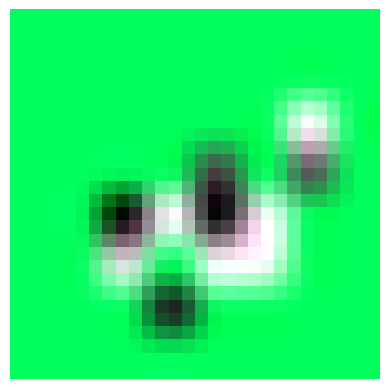

In [7]:
# VERY IMPORTANT !!!!!!!
# Check this to make sure that the model didn't "cheat" by removing the colored corner boxes for weakly learned features.
# If you don't transform it correctly, it achieves extremely high accuracy that way.

import torchvision.transforms as T
image = T.ToPILImage()(bias_trainset[9][0]).resize((28, 28))
import matplotlib.pyplot as plt

plt.imshow(image)
plt.axis("off")

In [ ]:

bias_loader = DataLoader(bias_trainset, batch_size=64, shuffle=True)

bias_model = SmallBiasedMNISTModel(num_classes=num_classes).to(device)
bias_model = train_bias_model(bias_model, bias_loader, device, epochs=2)

Training bias model (Resolution: Low) for 2 epochs...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating group-wise accuracy:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:11,  2.09it/s]

Group (0, 0) Accuracy: 100.0


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:00<00:09,  2.45it/s]

Group (0, 1) Accuracy: 0.0


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:01<00:08,  2.61it/s]

Group (0, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:01<00:07,  2.68it/s]

Group (0, 3) Accuracy: 0.0


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:01<00:07,  2.67it/s]

Group (0, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:02<00:06,  2.73it/s]

Group (1, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:02<00:06,  2.76it/s]

Group (1, 1) Accuracy: 100.0


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:03<00:06,  2.74it/s]

Group (1, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:03<00:05,  2.75it/s]

Group (1, 3) Accuracy: 0.0


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:03<00:05,  2.76it/s]

Group (1, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:04<00:05,  2.74it/s]

Group (2, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:04<00:04,  2.79it/s]

Group (2, 1) Accuracy: 0.0


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:04<00:04,  2.82it/s]

Group (2, 2) Accuracy: 100.0


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:05<00:04,  2.61it/s]

Group (2, 3) Accuracy: 0.0


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:05<00:03,  2.68it/s]

Group (2, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:05<00:03,  2.71it/s]

Group (3, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:06<00:02,  2.69it/s]

Group (3, 1) Accuracy: 0.0


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:06<00:02,  2.74it/s]

Group (3, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:07<00:02,  2.75it/s]

Group (3, 3) Accuracy: 100.0


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:07<00:01,  2.72it/s]

Group (3, 4) Accuracy: 0.0


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:07<00:01,  2.72it/s]

Group (4, 0) Accuracy: 0.0


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:08<00:01,  2.73it/s]

Group (4, 1) Accuracy: 0.0


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:08<00:00,  2.60it/s]

Group (4, 2) Accuracy: 0.0


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:09<00:00,  2.06it/s]

Group (4, 3) Accuracy: 0.0


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]

Group (4, 4) Accuracy: 100.0

Worst group accuracy:  ((0, 1), 0.0)

Average accuracy: 20.0
{(0, 0): 100.0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): 0.0, (0, 4): 0.0, (1, 0): 0.0, (1, 1): 100.0, (1, 2): 0.0, (1, 3): 0.0, (1, 4): 0.0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 100.0, (2, 3): 0.0, (2, 4): 0.0, (3, 0): 0.0, (3, 1): 0.0, (3, 2): 0.0, (3, 3): 100.0, (3, 4): 0.0, (4, 0): 0.0, (4, 1): 0.0, (4, 2): 0.0, (4, 3): 0.0, (4, 4): 100.0}


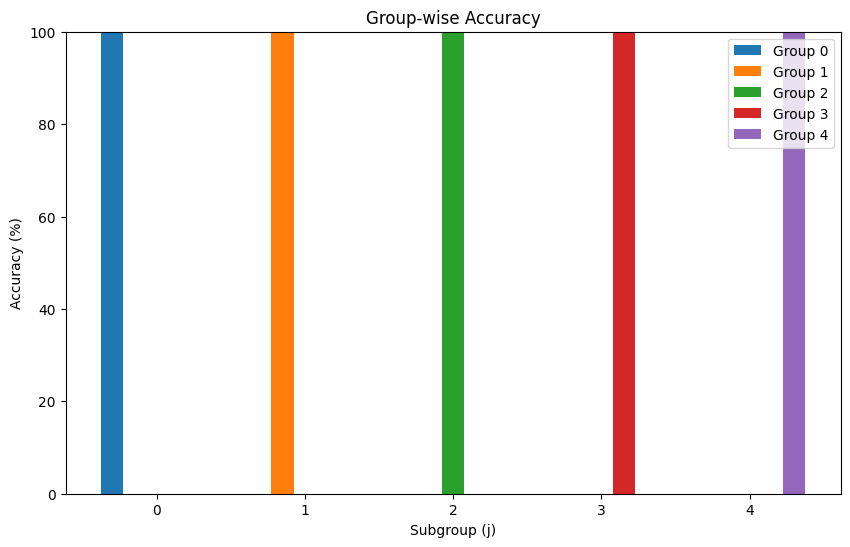

In [ ]:
# Small check: Did my model learn the spurious feature?

from spuco.evaluate import Evaluator

# From hw
spurious_test_ds = SpuCoMNIST(root="data/dataset",
                     spurious_feature_difficulty=difficulty,
                     classes=Classes,
                     spurious_correlation_strength=correlation_strength,
                     split="test",
                     download=True,
                     transform=low_res_transform)
spurious_test_ds.initialize()

evaluator = Evaluator(
    testset=spurious_test_ds,
    group_partition=spurious_test_ds.group_partition,
    group_weights=spurious_test_ds.group_weights,
    batch_size=64,
    model=bias_model,
    device=device,
    verbose=True
)
evaluator.evaluate()
print("Worst group accuracy: ", evaluator.worst_group_accuracy)
print("Average accuracy:", evaluator.average_accuracy)

print(evaluator.accuracies)

import matplotlib.pyplot as plt

accuracy_dict = evaluator.accuracies

groups = sorted(set(key[0] for key in accuracy_dict.keys()))
subgroups = sorted(set(key[1] for key in accuracy_dict.keys()))

data = [[accuracy_dict[(i, j)] for j in subgroups] for i in groups]

# Bar graph parameters
x = np.arange(len(subgroups))  # x locations for subgroups
width = 0.15  # width of each bar

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each group
for i, group_data in enumerate(data):
    ax.bar(x + i*width, group_data, width, label=f'Group {i}')

ax.set_xlabel('Subgroup (j)')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Group-wise Accuracy')
ax.set_xticks(x + width * (len(groups)-1)/2)
ax.set_xticklabels(subgroups)
ax.set_ylim(0, 100)
ax.legend()

plt.show()

n_clusters 25
n_cluster actual Counter({np.int32(0): 9623, np.int32(4): 8965, np.int32(2): 6531, np.int32(18): 5893, np.int32(3): 5588, np.int32(1): 3805, np.int32(6): 3805, np.int32(20): 3551, np.int32(5): 29, np.int32(9): 22, np.int32(17): 18, np.int32(19): 16, np.int32(10): 15, np.int32(8): 15, np.int32(11): 14, np.int32(24): 14, np.int32(23): 14, np.int32(12): 13, np.int32(15): 12, np.int32(14): 12, np.int32(22): 12, np.int32(21): 10, np.int32(16): 10, np.int32(13): 9, np.int32(7): 8})
smallest cluster 8


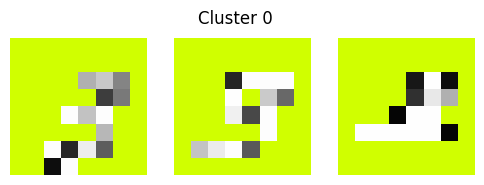

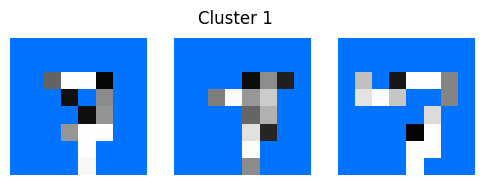

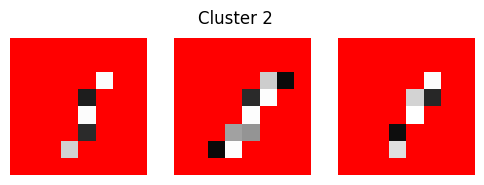

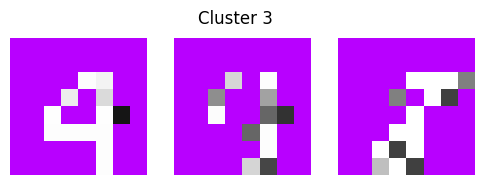

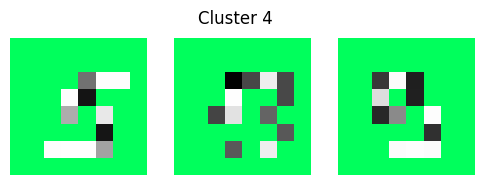

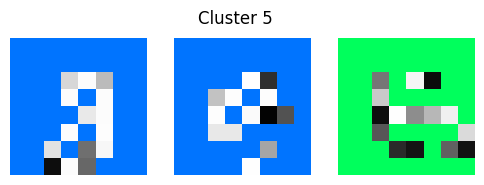

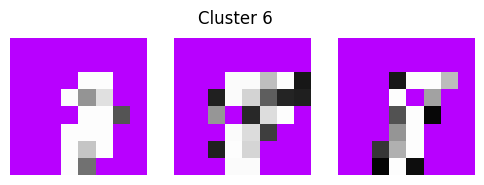

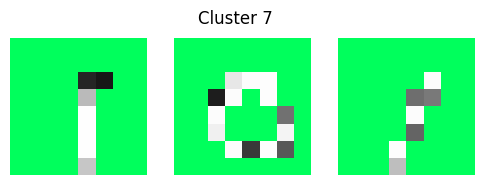

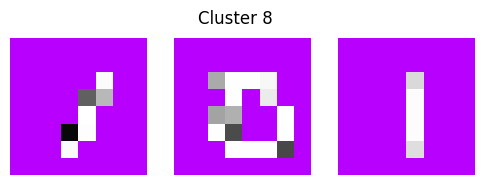

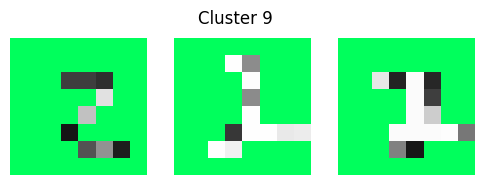

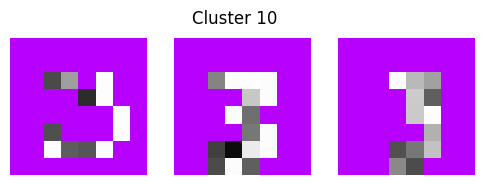

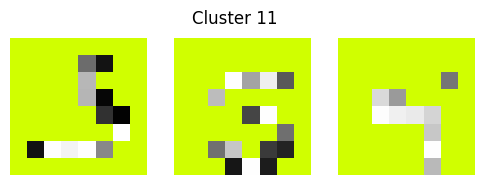

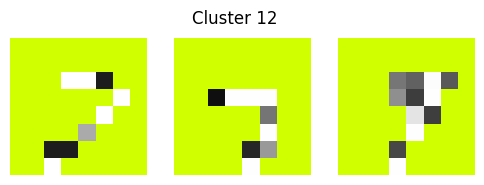

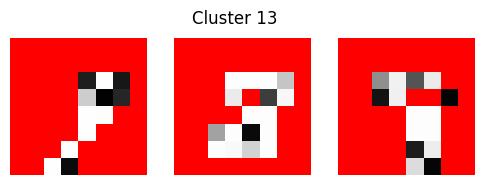

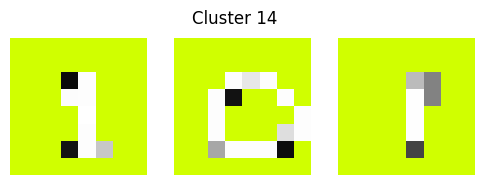

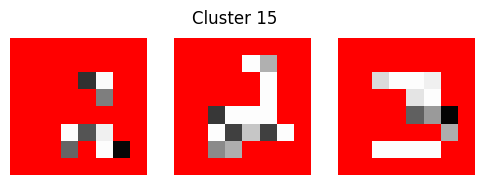

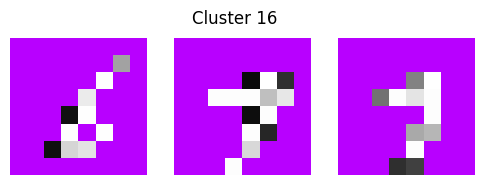

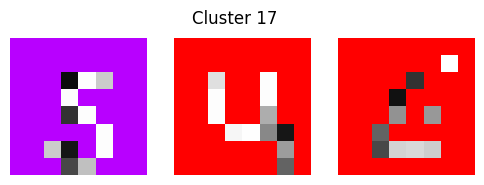

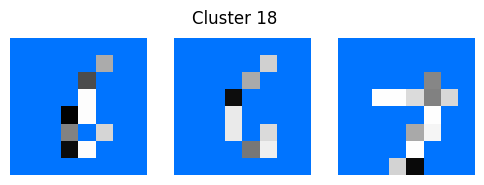

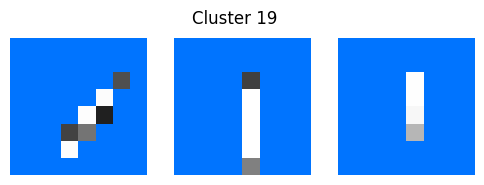

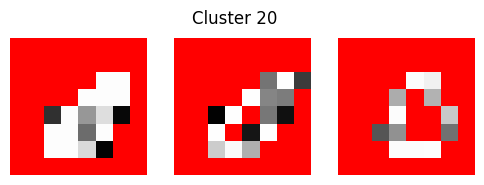

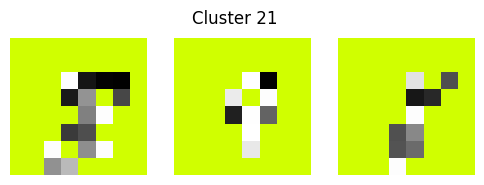

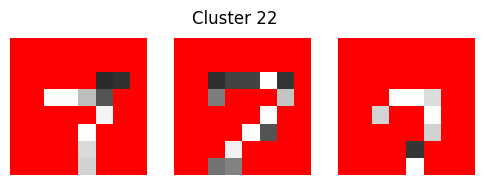

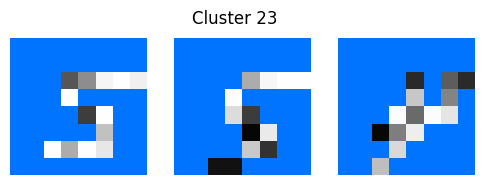

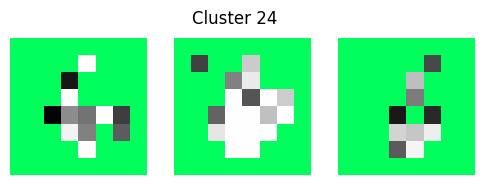

Data Selection: Kept 200 / 48004 samples
Data selection done


In [ ]:


selected_indices = get_logits_and_cluster(bias_model, final_trainset_selector, device, n_clusters=25)

print(f"Data Selection: Kept {len(selected_indices)} / {len(final_trainset)} samples")


#Create the "Clean" Subset using indices derived from the low-res model
clean_dataset = Subset(final_trainset, selected_indices)


print("Data selection done")


[1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]


Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 270, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 427, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 384, in _send
    n = write(self._handle, buf)
        ^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 9] Bad file descriptor
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exc

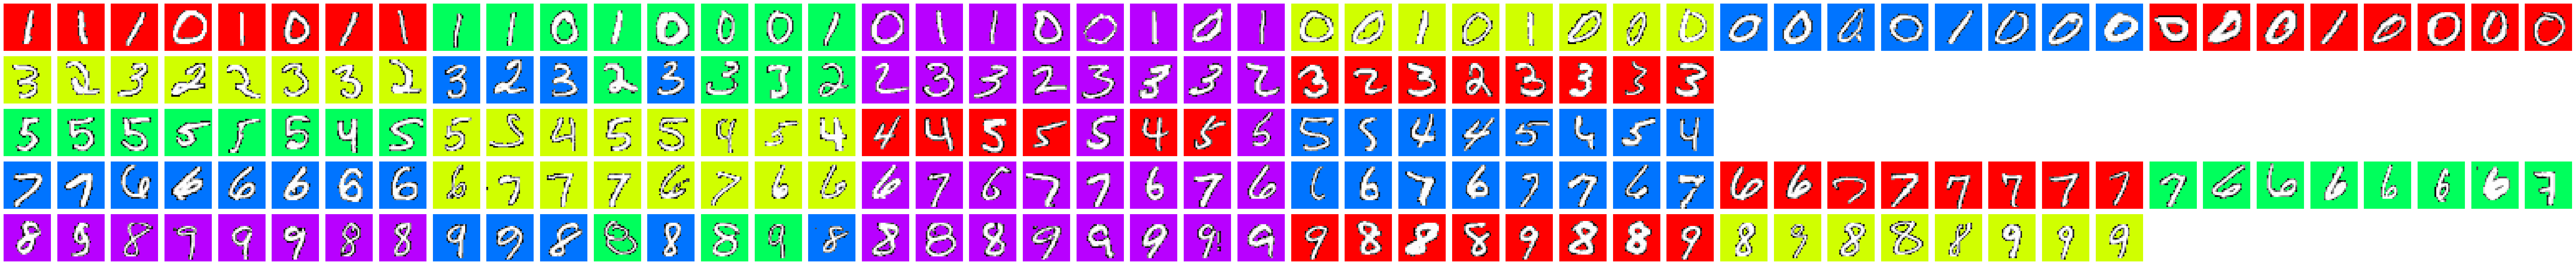

Number of images in label 2: 32
First image shape: torch.Size([3, 28, 28])


In [50]:

print([i[1] for i in clean_dataset])
data = [[] for _ in range(5)]
for i in clean_dataset:
  dat = i[0]
  label = i[1]
  data[label].append(dat)

import matplotlib.pyplot as plt

num_labels = len(data)
max_cols = max(len(array) for array in data)  # find the row with the most images

fig, axes = plt.subplots(num_labels, max_cols, figsize=(max_cols*1.5, num_labels*1.5), squeeze=False)

for row, array in enumerate(data):
    for col in range(max_cols):
        ax = axes[row][col]
        if col < len(array):
            img = array[col]
            if img.ndim == 3:  # (C, H, W) → (H, W, C)
                img = img.permute(1, 2, 0)
            ax.imshow(img.squeeze(), cmap='gray' if img.ndim == 2 else None)
        ax.axis("off")
    axes[row][0].set_ylabel(f"Label {row}", rotation=0, labelpad=30)

plt.tight_layout()
plt.show()

images_label_2 = data[2]

print(f"Number of images in label 2: {len(images_label_2)}")
print(f"First image shape: {images_label_2[0].shape}")

In [49]:

input_size = final_trainset[0][0].shape
num_labels = final_trainset.num_classes
model_lenet = model_factory("lenet", input_size, num_labels).to(device)

optimizer_adam = Adam(
    model_lenet.parameters(),
    lr=0.0005
)
ermtrainer = ERM(
    trainset=clean_dataset,
    model=model_lenet,
    num_epochs=21,
    batch_size=8,
    optimizer=optimizer_adam,
    device=device,
    verbose=True
)

# Start training
ermtrainer.train()


Epoch 0:  12%|█▏        | 3/25 [00:01<00:06,  3.62batch/s, accuracy=37.5%, loss=1.58]

ERM | Epoch 0 | Loss: 1.595123052597046 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.6370762586593628 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6263039112091064 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.5818157196044922 | Accuracy: 37.5%


Epoch 0:  32%|███▏      | 8/25 [00:01<00:01,  9.96batch/s, accuracy=0.0%, loss=1.67] 

ERM | Epoch 0 | Loss: 1.6056768894195557 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.5518563985824585 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.582801103591919 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.6356842517852783 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.6217467784881592 | Accuracy: 25.0%


Epoch 0:  52%|█████▏    | 13/25 [00:01<00:00, 13.92batch/s, accuracy=25.0%, loss=1.61]

ERM | Epoch 0 | Loss: 1.666023850440979 | Accuracy: 0.0%
ERM | Epoch 0 | Loss: 1.5464551448822021 | Accuracy: 62.5%
ERM | Epoch 0 | Loss: 1.6113911867141724 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.6135348081588745 | Accuracy: 25.0%


Epoch 0:  60%|██████    | 15/25 [00:01<00:00, 14.39batch/s, accuracy=0.0%, loss=1.65] 

ERM | Epoch 0 | Loss: 1.6564692258834839 | Accuracy: 0.0%
ERM | Epoch 0 | Loss: 1.5814069509506226 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.649233102798462 | Accuracy: 0.0%


Epoch 0:  76%|███████▌  | 19/25 [00:01<00:00, 13.92batch/s, accuracy=37.5%, loss=1.57]

ERM | Epoch 0 | Loss: 1.6114705801010132 | Accuracy: 37.5%
ERM | Epoch 0 | Loss: 1.5813138484954834 | Accuracy: 50.0%
ERM | Epoch 0 | Loss: 1.568453311920166 | Accuracy: 37.5%


Epoch 0:  84%|████████▍ | 21/25 [00:02<00:00, 12.84batch/s, accuracy=37.5%, loss=1.58]

ERM | Epoch 0 | Loss: 1.603654146194458 | Accuracy: 12.5%
ERM | Epoch 0 | Loss: 1.6640713214874268 | Accuracy: 0.0%
ERM | Epoch 0 | Loss: 1.5796611309051514 | Accuracy: 37.5%


Epoch 0:  92%|█████████▏| 23/25 [00:02<00:00, 12.37batch/s, accuracy=25.0%, loss=1.6]

ERM | Epoch 0 | Loss: 1.6019949913024902 | Accuracy: 25.0%
ERM | Epoch 0 | Loss: 1.6000959873199463 | Accuracy: 25.0%


Epoch 0: 100%|██████████| 25/25 [00:02<00:00, 10.62batch/s, accuracy=12.5%, loss=1.61]

ERM | Epoch 0 | Loss: 1.6106488704681396 | Accuracy: 12.5%


Epoch 1:  12%|█▏        | 3/25 [00:00<00:05,  3.99batch/s, accuracy=25.0%, loss=1.6]

ERM | Epoch 1 | Loss: 1.565246343612671 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.5641824007034302 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.6317716836929321 | Accuracy: 0.0%
ERM | Epoch 1 | Loss: 1.5979636907577515 | Accuracy: 25.0%


Epoch 1:  36%|███▌      | 9/25 [00:01<00:01, 12.07batch/s, accuracy=25.0%, loss=1.58]

ERM | Epoch 1 | Loss: 1.5817515850067139 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.6298854351043701 | Accuracy: 0.0%
ERM | Epoch 1 | Loss: 1.6250386238098145 | Accuracy: 0.0%
ERM | Epoch 1 | Loss: 1.566885232925415 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.6247336864471436 | Accuracy: 0.0%
ERM | Epoch 1 | Loss: 1.5761277675628662 | Accuracy: 25.0%


Epoch 1:  48%|████▊     | 12/25 [00:01<00:00, 14.90batch/s, accuracy=0.0%, loss=1.62]

ERM | Epoch 1 | Loss: 1.5859826803207397 | Accuracy: 12.5%
ERM | Epoch 1 | Loss: 1.521864414215088 | Accuracy: 75.0%
ERM | Epoch 1 | Loss: 1.5952672958374023 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.6248958110809326 | Accuracy: 0.0%


Epoch 1:  72%|███████▏  | 18/25 [00:01<00:00, 18.02batch/s, accuracy=37.5%, loss=1.57]

ERM | Epoch 1 | Loss: 1.6458687782287598 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.5165754556655884 | Accuracy: 50.0%
ERM | Epoch 1 | Loss: 1.7016074657440186 | Accuracy: 12.5%
ERM | Epoch 1 | Loss: 1.5810418128967285 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.569403052330017 | Accuracy: 37.5%


Epoch 1:  96%|█████████▌| 24/25 [00:01<00:00, 18.92batch/s, accuracy=25.0%, loss=1.56]

ERM | Epoch 1 | Loss: 1.6207355260849 | Accuracy: 25.0%
ERM | Epoch 1 | Loss: 1.6799887418746948 | Accuracy: 0.0%
ERM | Epoch 1 | Loss: 1.626854419708252 | Accuracy: 37.5%
ERM | Epoch 1 | Loss: 1.6613882780075073 | Accuracy: 0.0%
ERM | Epoch 1 | Loss: 1.557499885559082 | Accuracy: 25.0%


Epoch 1:  96%|█████████▌| 24/25 [00:01<00:00, 18.92batch/s, accuracy=25.0%, loss=1.59]

ERM | Epoch 1 | Loss: 1.5880582332611084 | Accuracy: 25.0%


Epoch 2:  12%|█▏        | 3/25 [00:00<00:05,  4.17batch/s, accuracy=25.0%, loss=1.62]

ERM | Epoch 2 | Loss: 1.5160502195358276 | Accuracy: 62.5%
ERM | Epoch 2 | Loss: 1.5827786922454834 | Accuracy: 50.0%
ERM | Epoch 2 | Loss: 1.600296139717102 | Accuracy: 12.5%
ERM | Epoch 2 | Loss: 1.632279396057129 | Accuracy: 37.5%
ERM | Epoch 2 | Loss: 1.617753505706787 | Accuracy: 25.0%


Epoch 2:  36%|███▌      | 9/25 [00:01<00:01, 12.47batch/s, accuracy=0.0%, loss=1.61] 

ERM | Epoch 2 | Loss: 1.5891497135162354 | Accuracy: 25.0%
ERM | Epoch 2 | Loss: 1.6430608034133911 | Accuracy: 0.0%
ERM | Epoch 2 | Loss: 1.64775812625885 | Accuracy: 0.0%
ERM | Epoch 2 | Loss: 1.606136679649353 | Accuracy: 50.0%
ERM | Epoch 2 | Loss: 1.6053420305252075 | Accuracy: 0.0%


Epoch 2:  60%|██████    | 15/25 [00:01<00:00, 18.03batch/s, accuracy=25.0%, loss=1.57]

ERM | Epoch 2 | Loss: 1.5640901327133179 | Accuracy: 12.5%
ERM | Epoch 2 | Loss: 1.6092324256896973 | Accuracy: 25.0%
ERM | Epoch 2 | Loss: 1.6378350257873535 | Accuracy: 12.5%
ERM | Epoch 2 | Loss: 1.5807524919509888 | Accuracy: 12.5%
ERM | Epoch 2 | Loss: 1.606629490852356 | Accuracy: 25.0%
ERM | Epoch 2 | Loss: 1.566201090812683 | Accuracy: 25.0%


Epoch 2:  84%|████████▍ | 21/25 [00:01<00:00, 21.97batch/s, accuracy=37.5%, loss=1.57]

ERM | Epoch 2 | Loss: 1.553423523902893 | Accuracy: 12.5%
ERM | Epoch 2 | Loss: 1.5811785459518433 | Accuracy: 50.0%
ERM | Epoch 2 | Loss: 1.609223484992981 | Accuracy: 37.5%
ERM | Epoch 2 | Loss: 1.6351540088653564 | Accuracy: 37.5%
ERM | Epoch 2 | Loss: 1.5615270137786865 | Accuracy: 25.0%
ERM | Epoch 2 | Loss: 1.5737210512161255 | Accuracy: 37.5%


Epoch 2:  96%|█████████▌| 24/25 [00:01<00:00, 22.22batch/s, accuracy=0.0%, loss=1.64] 

ERM | Epoch 2 | Loss: 1.5373035669326782 | Accuracy: 25.0%
ERM | Epoch 2 | Loss: 1.529266119003296 | Accuracy: 37.5%
ERM | Epoch 2 | Loss: 1.6427010297775269 | Accuracy: 0.0%


Epoch 3:  16%|█▌        | 4/25 [00:00<00:03,  5.70batch/s, accuracy=37.5%, loss=1.57]

ERM | Epoch 3 | Loss: 1.5615406036376953 | Accuracy: 37.5%
ERM | Epoch 3 | Loss: 1.5519742965698242 | Accuracy: 25.0%
ERM | Epoch 3 | Loss: 1.6632051467895508 | Accuracy: 12.5%
ERM | Epoch 3 | Loss: 1.6931627988815308 | Accuracy: 0.0%
ERM | Epoch 3 | Loss: 1.5665227174758911 | Accuracy: 37.5%


Epoch 3:  40%|████      | 10/25 [00:01<00:01, 12.65batch/s, accuracy=12.5%, loss=1.65]

ERM | Epoch 3 | Loss: 1.5804786682128906 | Accuracy: 62.5%
ERM | Epoch 3 | Loss: 1.6173967123031616 | Accuracy: 37.5%
ERM | Epoch 3 | Loss: 1.5327147245407104 | Accuracy: 25.0%
ERM | Epoch 3 | Loss: 1.5681941509246826 | Accuracy: 12.5%
ERM | Epoch 3 | Loss: 1.6456526517868042 | Accuracy: 12.5%


Epoch 3:  56%|█████▌    | 14/25 [00:01<00:00, 17.84batch/s, accuracy=0.0%, loss=1.54] 

ERM | Epoch 3 | Loss: 1.5012370347976685 | Accuracy: 75.0%
ERM | Epoch 3 | Loss: 1.6024274826049805 | Accuracy: 25.0%
ERM | Epoch 3 | Loss: 1.5904756784439087 | Accuracy: 0.0%
ERM | Epoch 3 | Loss: 1.544379711151123 | Accuracy: 25.0%
ERM | Epoch 3 | Loss: 1.6502963304519653 | Accuracy: 12.5%
ERM | Epoch 3 | Loss: 1.5225902795791626 | Accuracy: 25.0%
ERM | Epoch 3 | Loss: 1.5444073677062988 | Accuracy: 0.0%


Epoch 3:  88%|████████▊ | 22/25 [00:01<00:00, 24.17batch/s, accuracy=12.5%, loss=1.6] 

ERM | Epoch 3 | Loss: 1.6218916177749634 | Accuracy: 25.0%
ERM | Epoch 3 | Loss: 1.592372179031372 | Accuracy: 25.0%
ERM | Epoch 3 | Loss: 1.6399331092834473 | Accuracy: 12.5%
ERM | Epoch 3 | Loss: 1.5045585632324219 | Accuracy: 37.5%
ERM | Epoch 3 | Loss: 1.5214810371398926 | Accuracy: 50.0%
ERM | Epoch 3 | Loss: 1.6006126403808594 | Accuracy: 12.5%


Epoch 3: 100%|██████████| 25/25 [00:01<00:00, 21.76batch/s, accuracy=25.0%, loss=1.61]

ERM | Epoch 3 | Loss: 1.6235545873641968 | Accuracy: 25.0%
ERM | Epoch 3 | Loss: 1.606358289718628 | Accuracy: 25.0%


Epoch 4:  12%|█▏        | 3/25 [00:01<00:07,  2.91batch/s, accuracy=25.0%, loss=1.6]

ERM | Epoch 4 | Loss: 1.5193579196929932 | Accuracy: 50.0%
ERM | Epoch 4 | Loss: 1.5208895206451416 | Accuracy: 37.5%
ERM | Epoch 4 | Loss: 1.6002757549285889 | Accuracy: 25.0%


Epoch 4:  28%|██▊       | 7/25 [00:01<00:02,  6.65batch/s, accuracy=37.5%, loss=1.58]

ERM | Epoch 4 | Loss: 1.7342547178268433 | Accuracy: 0.0%
ERM | Epoch 4 | Loss: 1.6168429851531982 | Accuracy: 37.5%
ERM | Epoch 4 | Loss: 1.7246520519256592 | Accuracy: 12.5%
ERM | Epoch 4 | Loss: 1.5791693925857544 | Accuracy: 37.5%


Epoch 4:  44%|████▍     | 11/25 [00:01<00:01, 10.55batch/s, accuracy=12.5%, loss=1.53]

ERM | Epoch 4 | Loss: 1.5694745779037476 | Accuracy: 12.5%
ERM | Epoch 4 | Loss: 1.5450387001037598 | Accuracy: 12.5%
ERM | Epoch 4 | Loss: 1.557012915611267 | Accuracy: 12.5%
ERM | Epoch 4 | Loss: 1.5344433784484863 | Accuracy: 12.5%


Epoch 4:  60%|██████    | 15/25 [00:02<00:00, 12.94batch/s, accuracy=62.5%, loss=1.52]

ERM | Epoch 4 | Loss: 1.507922649383545 | Accuracy: 37.5%
ERM | Epoch 4 | Loss: 1.597702980041504 | Accuracy: 12.5%
ERM | Epoch 4 | Loss: 1.4968198537826538 | Accuracy: 50.0%
ERM | Epoch 4 | Loss: 1.517592430114746 | Accuracy: 62.5%


Epoch 4:  76%|███████▌  | 19/25 [00:02<00:00, 14.66batch/s, accuracy=25.0%, loss=1.57]

ERM | Epoch 4 | Loss: 1.5865108966827393 | Accuracy: 25.0%
ERM | Epoch 4 | Loss: 1.571542501449585 | Accuracy: 12.5%
ERM | Epoch 4 | Loss: 1.7219003438949585 | Accuracy: 25.0%
ERM | Epoch 4 | Loss: 1.5724414587020874 | Accuracy: 25.0%


Epoch 4:  88%|████████▊ | 22/25 [00:02<00:00, 17.05batch/s, accuracy=37.5%, loss=1.56]

ERM | Epoch 4 | Loss: 1.5729957818984985 | Accuracy: 37.5%
ERM | Epoch 4 | Loss: 1.4892101287841797 | Accuracy: 50.0%
ERM | Epoch 4 | Loss: 1.6481066942214966 | Accuracy: 0.0%
ERM | Epoch 4 | Loss: 1.583565354347229 | Accuracy: 12.5%
ERM | Epoch 4 | Loss: 1.6465063095092773 | Accuracy: 37.5%
ERM | Epoch 4 | Loss: 1.561416745185852 | Accuracy: 37.5%


Epoch 5:  16%|█▌        | 4/25 [00:00<00:03,  5.49batch/s, accuracy=37.5%, loss=1.61]

ERM | Epoch 5 | Loss: 1.6266388893127441 | Accuracy: 12.5%
ERM | Epoch 5 | Loss: 1.5579336881637573 | Accuracy: 25.0%
ERM | Epoch 5 | Loss: 1.5886361598968506 | Accuracy: 37.5%
ERM | Epoch 5 | Loss: 1.6108677387237549 | Accuracy: 37.5%


Epoch 5:  40%|████      | 10/25 [00:01<00:01, 12.67batch/s, accuracy=62.5%, loss=1.46]

ERM | Epoch 5 | Loss: 1.644536018371582 | Accuracy: 12.5%
ERM | Epoch 5 | Loss: 1.5678589344024658 | Accuracy: 37.5%
ERM | Epoch 5 | Loss: 1.5470778942108154 | Accuracy: 37.5%
ERM | Epoch 5 | Loss: 1.4646461009979248 | Accuracy: 50.0%
ERM | Epoch 5 | Loss: 1.7110683917999268 | Accuracy: 12.5%
ERM | Epoch 5 | Loss: 1.4569636583328247 | Accuracy: 62.5%


Epoch 5:  56%|█████▌    | 14/25 [00:01<00:00, 16.93batch/s, accuracy=37.5%, loss=1.58]

ERM | Epoch 5 | Loss: 1.57724928855896 | Accuracy: 50.0%
ERM | Epoch 5 | Loss: 1.4727997779846191 | Accuracy: 37.5%
ERM | Epoch 5 | Loss: 1.5249450206756592 | Accuracy: 37.5%
ERM | Epoch 5 | Loss: 1.6129117012023926 | Accuracy: 25.0%
ERM | Epoch 5 | Loss: 1.5069947242736816 | Accuracy: 37.5%
ERM | Epoch 5 | Loss: 1.5843796730041504 | Accuracy: 37.5%


Epoch 5:  84%|████████▍ | 21/25 [00:01<00:00, 23.04batch/s, accuracy=12.5%, loss=1.65]

ERM | Epoch 5 | Loss: 1.5849766731262207 | Accuracy: 25.0%
ERM | Epoch 5 | Loss: 1.7845346927642822 | Accuracy: 12.5%
ERM | Epoch 5 | Loss: 1.5935938358306885 | Accuracy: 25.0%
ERM | Epoch 5 | Loss: 1.448278784751892 | Accuracy: 50.0%
ERM | Epoch 5 | Loss: 1.600490689277649 | Accuracy: 25.0%
ERM | Epoch 5 | Loss: 1.6247080564498901 | Accuracy: 25.0%
ERM | Epoch 5 | Loss: 1.6499876976013184 | Accuracy: 12.5%


Epoch 5:  96%|█████████▌| 24/25 [00:01<00:00, 22.18batch/s, accuracy=25.0%, loss=1.49]

ERM | Epoch 5 | Loss: 1.468111276626587 | Accuracy: 50.0%
ERM | Epoch 5 | Loss: 1.4868221282958984 | Accuracy: 25.0%


Epoch 6:  12%|█▏        | 3/25 [00:01<00:07,  2.92batch/s, accuracy=12.5%, loss=1.63]

ERM | Epoch 6 | Loss: 1.5041836500167847 | Accuracy: 62.5%
ERM | Epoch 6 | Loss: 1.522945761680603 | Accuracy: 50.0%
ERM | Epoch 6 | Loss: 1.559605360031128 | Accuracy: 25.0%
ERM | Epoch 6 | Loss: 1.6300418376922607 | Accuracy: 12.5%


Epoch 6:  32%|███▏      | 8/25 [00:01<00:02,  8.47batch/s, accuracy=37.5%, loss=1.55]

ERM | Epoch 6 | Loss: 1.4801089763641357 | Accuracy: 50.0%
ERM | Epoch 6 | Loss: 1.4995464086532593 | Accuracy: 50.0%
ERM | Epoch 6 | Loss: 1.6537007093429565 | Accuracy: 12.5%
ERM | Epoch 6 | Loss: 1.5583856105804443 | Accuracy: 25.0%
ERM | Epoch 6 | Loss: 1.6298322677612305 | Accuracy: 62.5%


Epoch 6:  56%|█████▌    | 14/25 [00:01<00:00, 14.96batch/s, accuracy=37.5%, loss=1.61]

ERM | Epoch 6 | Loss: 1.5509026050567627 | Accuracy: 37.5%
ERM | Epoch 6 | Loss: 1.57462477684021 | Accuracy: 25.0%
ERM | Epoch 6 | Loss: 1.4938867092132568 | Accuracy: 50.0%
ERM | Epoch 6 | Loss: 1.5615136623382568 | Accuracy: 25.0%
ERM | Epoch 6 | Loss: 1.4802626371383667 | Accuracy: 50.0%
ERM | Epoch 6 | Loss: 1.614650011062622 | Accuracy: 37.5%


Epoch 6:  80%|████████  | 20/25 [00:02<00:00, 19.30batch/s, accuracy=50.0%, loss=1.49]

ERM | Epoch 6 | Loss: 1.5791500806808472 | Accuracy: 12.5%
ERM | Epoch 6 | Loss: 1.5297722816467285 | Accuracy: 25.0%
ERM | Epoch 6 | Loss: 1.7120401859283447 | Accuracy: 0.0%
ERM | Epoch 6 | Loss: 1.6567130088806152 | Accuracy: 50.0%
ERM | Epoch 6 | Loss: 1.51450777053833 | Accuracy: 50.0%
ERM | Epoch 6 | Loss: 1.4913606643676758 | Accuracy: 50.0%


Epoch 6:  92%|█████████▏| 23/25 [00:02<00:00, 20.47batch/s, accuracy=50.0%, loss=1.53]

ERM | Epoch 6 | Loss: 1.4578969478607178 | Accuracy: 62.5%
ERM | Epoch 6 | Loss: 1.4705719947814941 | Accuracy: 50.0%
ERM | Epoch 6 | Loss: 1.6972110271453857 | Accuracy: 25.0%
ERM | Epoch 6 | Loss: 1.5260928869247437 | Accuracy: 50.0%


Epoch 7:  20%|██        | 5/25 [00:00<00:02,  8.77batch/s, accuracy=62.5%, loss=1.44]

ERM | Epoch 7 | Loss: 1.488763451576233 | Accuracy: 25.0%
ERM | Epoch 7 | Loss: 1.6051740646362305 | Accuracy: 25.0%
ERM | Epoch 7 | Loss: 1.4652529954910278 | Accuracy: 50.0%
ERM | Epoch 7 | Loss: 1.6213291883468628 | Accuracy: 37.5%
ERM | Epoch 7 | Loss: 1.485630989074707 | Accuracy: 62.5%
ERM | Epoch 7 | Loss: 1.5991990566253662 | Accuracy: 37.5%
ERM | Epoch 7 | Loss: 1.593882441520691 | Accuracy: 12.5%
ERM | Epoch 7 | Loss: 1.4412517547607422 | Accuracy: 37.5%
ERM | Epoch 7 | Loss: 1.5595886707305908 | Accuracy: 25.0%
ERM | Epoch 7 | Loss: 1.4436956644058228 | Accuracy: 62.5%


Epoch 7:  64%|██████▍   | 16/25 [00:01<00:00, 25.19batch/s, accuracy=12.5%, loss=1.68]

ERM | Epoch 7 | Loss: 1.500352144241333 | Accuracy: 25.0%
ERM | Epoch 7 | Loss: 1.667895793914795 | Accuracy: 37.5%
ERM | Epoch 7 | Loss: 1.4959931373596191 | Accuracy: 50.0%
ERM | Epoch 7 | Loss: 1.6570535898208618 | Accuracy: 12.5%
ERM | Epoch 7 | Loss: 1.4517953395843506 | Accuracy: 62.5%
ERM | Epoch 7 | Loss: 1.7489633560180664 | Accuracy: 12.5%
ERM | Epoch 7 | Loss: 1.597713828086853 | Accuracy: 25.0%
ERM | Epoch 7 | Loss: 1.5760947465896606 | Accuracy: 37.5%
ERM | Epoch 7 | Loss: 1.4789848327636719 | Accuracy: 25.0%
ERM | Epoch 7 | Loss: 1.4120253324508667 | Accuracy: 50.0%


Epoch 7:  88%|████████▊ | 22/25 [00:01<00:00, 32.18batch/s, accuracy=50.0%, loss=1.46]

ERM | Epoch 7 | Loss: 1.6796860694885254 | Accuracy: 12.5%
ERM | Epoch 7 | Loss: 1.485974907875061 | Accuracy: 37.5%
ERM | Epoch 7 | Loss: 1.6498212814331055 | Accuracy: 12.5%
ERM | Epoch 7 | Loss: 1.4413939714431763 | Accuracy: 50.0%
ERM | Epoch 7 | Loss: 1.4630829095840454 | Accuracy: 50.0%


Epoch 8:  20%|██        | 5/25 [00:00<00:01, 10.57batch/s, accuracy=62.5%, loss=1.41]

ERM | Epoch 8 | Loss: 1.5889637470245361 | Accuracy: 37.5%
ERM | Epoch 8 | Loss: 1.3807764053344727 | Accuracy: 37.5%
ERM | Epoch 8 | Loss: 1.5994446277618408 | Accuracy: 25.0%
ERM | Epoch 8 | Loss: 1.615566372871399 | Accuracy: 37.5%
ERM | Epoch 8 | Loss: 1.6125797033309937 | Accuracy: 12.5%
ERM | Epoch 8 | Loss: 1.4862303733825684 | Accuracy: 62.5%
ERM | Epoch 8 | Loss: 1.5415209531784058 | Accuracy: 37.5%
ERM | Epoch 8 | Loss: 1.412369966506958 | Accuracy: 62.5%


Epoch 8:  52%|█████▏    | 13/25 [00:00<00:00, 22.29batch/s, accuracy=37.5%, loss=1.49]

ERM | Epoch 8 | Loss: 1.5891456604003906 | Accuracy: 37.5%
ERM | Epoch 8 | Loss: 1.5955833196640015 | Accuracy: 37.5%
ERM | Epoch 8 | Loss: 1.481701374053955 | Accuracy: 37.5%
ERM | Epoch 8 | Loss: 1.4990438222885132 | Accuracy: 12.5%
ERM | Epoch 8 | Loss: 1.546048641204834 | Accuracy: 50.0%
ERM | Epoch 8 | Loss: 1.660268783569336 | Accuracy: 12.5%
ERM | Epoch 8 | Loss: 1.3046175241470337 | Accuracy: 87.5%
ERM | Epoch 8 | Loss: 1.4887856245040894 | Accuracy: 37.5%


Epoch 8:  88%|████████▊ | 22/25 [00:01<00:00, 31.84batch/s, accuracy=25.0%, loss=1.43]

ERM | Epoch 8 | Loss: 1.525948166847229 | Accuracy: 37.5%
ERM | Epoch 8 | Loss: 1.50226628780365 | Accuracy: 12.5%
ERM | Epoch 8 | Loss: 1.5967146158218384 | Accuracy: 12.5%
ERM | Epoch 8 | Loss: 1.3985631465911865 | Accuracy: 50.0%
ERM | Epoch 8 | Loss: 1.6664466857910156 | Accuracy: 37.5%
ERM | Epoch 8 | Loss: 1.573911428451538 | Accuracy: 12.5%
ERM | Epoch 8 | Loss: 1.3729674816131592 | Accuracy: 62.5%
ERM | Epoch 8 | Loss: 1.6143567562103271 | Accuracy: 25.0%
ERM | Epoch 8 | Loss: 1.4346355199813843 | Accuracy: 25.0%


Epoch 9:  16%|█▌        | 4/25 [00:00<00:02,  7.89batch/s, accuracy=25.0%, loss=1.63]

ERM | Epoch 9 | Loss: 1.3571187257766724 | Accuracy: 50.0%
ERM | Epoch 9 | Loss: 1.6067241430282593 | Accuracy: 37.5%
ERM | Epoch 9 | Loss: 1.4363412857055664 | Accuracy: 50.0%
ERM | Epoch 9 | Loss: 1.48639976978302 | Accuracy: 37.5%
ERM | Epoch 9 | Loss: 1.5818291902542114 | Accuracy: 25.0%
ERM | Epoch 9 | Loss: 1.6296579837799072 | Accuracy: 25.0%


Epoch 9:  52%|█████▏    | 13/25 [00:00<00:00, 22.58batch/s, accuracy=50.0%, loss=1.32]

ERM | Epoch 9 | Loss: 1.386273741722107 | Accuracy: 37.5%
ERM | Epoch 9 | Loss: 1.4104955196380615 | Accuracy: 62.5%
ERM | Epoch 9 | Loss: 1.3689725399017334 | Accuracy: 62.5%
ERM | Epoch 9 | Loss: 1.3140956163406372 | Accuracy: 50.0%
ERM | Epoch 9 | Loss: 1.5450767278671265 | Accuracy: 25.0%
ERM | Epoch 9 | Loss: 1.6119709014892578 | Accuracy: 37.5%
ERM | Epoch 9 | Loss: 1.6133265495300293 | Accuracy: 12.5%
ERM | Epoch 9 | Loss: 1.4319933652877808 | Accuracy: 37.5%
ERM | Epoch 9 | Loss: 1.3207423686981201 | Accuracy: 50.0%


Epoch 9:  88%|████████▊ | 22/25 [00:01<00:00, 31.38batch/s, accuracy=25.0%, loss=1.59]

ERM | Epoch 9 | Loss: 1.3790417909622192 | Accuracy: 50.0%
ERM | Epoch 9 | Loss: 1.7499951124191284 | Accuracy: 37.5%
ERM | Epoch 9 | Loss: 1.3497780561447144 | Accuracy: 75.0%
ERM | Epoch 9 | Loss: 1.3593288660049438 | Accuracy: 50.0%
ERM | Epoch 9 | Loss: 1.5167889595031738 | Accuracy: 12.5%
ERM | Epoch 9 | Loss: 1.6310033798217773 | Accuracy: 12.5%
ERM | Epoch 9 | Loss: 1.400102138519287 | Accuracy: 50.0%
ERM | Epoch 9 | Loss: 1.5523567199707031 | Accuracy: 12.5%
ERM | Epoch 9 | Loss: 1.592355728149414 | Accuracy: 25.0%


Epoch 9:  88%|████████▊ | 22/25 [00:01<00:00, 31.38batch/s, accuracy=12.5%, loss=1.66]

ERM | Epoch 9 | Loss: 1.65614652633667 | Accuracy: 12.5%


Epoch 10:  24%|██▍       | 6/25 [00:00<00:01, 12.51batch/s, accuracy=62.5%, loss=1.32]

ERM | Epoch 10 | Loss: 1.1286200284957886 | Accuracy: 62.5%
ERM | Epoch 10 | Loss: 1.3689446449279785 | Accuracy: 50.0%
ERM | Epoch 10 | Loss: 1.5315427780151367 | Accuracy: 25.0%
ERM | Epoch 10 | Loss: 1.4579410552978516 | Accuracy: 37.5%
ERM | Epoch 10 | Loss: 1.3042163848876953 | Accuracy: 50.0%
ERM | Epoch 10 | Loss: 1.3248871564865112 | Accuracy: 50.0%
ERM | Epoch 10 | Loss: 1.8786122798919678 | Accuracy: 0.0%
ERM | Epoch 10 | Loss: 1.3993704319000244 | Accuracy: 37.5%
ERM | Epoch 10 | Loss: 1.3154772520065308 | Accuracy: 62.5%


Epoch 10:  64%|██████▍   | 16/25 [00:00<00:00, 28.11batch/s, accuracy=12.5%, loss=1.56]

ERM | Epoch 10 | Loss: 1.4398901462554932 | Accuracy: 37.5%
ERM | Epoch 10 | Loss: 1.5004408359527588 | Accuracy: 12.5%
ERM | Epoch 10 | Loss: 1.3577858209609985 | Accuracy: 37.5%
ERM | Epoch 10 | Loss: 1.3788832426071167 | Accuracy: 25.0%
ERM | Epoch 10 | Loss: 1.5370018482208252 | Accuracy: 37.5%
ERM | Epoch 10 | Loss: 1.5608316659927368 | Accuracy: 25.0%
ERM | Epoch 10 | Loss: 1.2365905046463013 | Accuracy: 50.0%
ERM | Epoch 10 | Loss: 1.461160659790039 | Accuracy: 50.0%
ERM | Epoch 10 | Loss: 1.319055438041687 | Accuracy: 50.0%
ERM | Epoch 10 | Loss: 1.5625426769256592 | Accuracy: 12.5%


Epoch 10:  84%|████████▍ | 21/25 [00:00<00:00, 33.66batch/s, accuracy=50.0%, loss=1.36]

ERM | Epoch 10 | Loss: 1.404742956161499 | Accuracy: 37.5%
ERM | Epoch 10 | Loss: 1.251238465309143 | Accuracy: 62.5%
ERM | Epoch 10 | Loss: 1.5290799140930176 | Accuracy: 37.5%
ERM | Epoch 10 | Loss: 1.526449203491211 | Accuracy: 37.5%
ERM | Epoch 10 | Loss: 1.3022236824035645 | Accuracy: 37.5%
ERM | Epoch 10 | Loss: 1.3591573238372803 | Accuracy: 50.0%


Epoch 11:  24%|██▍       | 6/25 [00:00<00:01, 11.89batch/s, accuracy=37.5%, loss=1.55]

ERM | Epoch 11 | Loss: 1.50480318069458 | Accuracy: 12.5%
ERM | Epoch 11 | Loss: 1.4850317239761353 | Accuracy: 37.5%
ERM | Epoch 11 | Loss: 1.4198918342590332 | Accuracy: 37.5%
ERM | Epoch 11 | Loss: 1.5122982263565063 | Accuracy: 62.5%
ERM | Epoch 11 | Loss: 1.121652364730835 | Accuracy: 75.0%
ERM | Epoch 11 | Loss: 1.3994777202606201 | Accuracy: 37.5%
ERM | Epoch 11 | Loss: 1.1523350477218628 | Accuracy: 50.0%
ERM | Epoch 11 | Loss: 1.2593122720718384 | Accuracy: 75.0%
ERM | Epoch 11 | Loss: 1.433011531829834 | Accuracy: 62.5%
ERM | Epoch 11 | Loss: 1.554351568222046 | Accuracy: 37.5%


Epoch 11:  60%|██████    | 15/25 [00:00<00:00, 24.84batch/s, accuracy=100.0%, loss=0.995]

ERM | Epoch 11 | Loss: 1.4283947944641113 | Accuracy: 37.5%
ERM | Epoch 11 | Loss: 1.3186671733856201 | Accuracy: 50.0%
ERM | Epoch 11 | Loss: 1.5347148180007935 | Accuracy: 12.5%
ERM | Epoch 11 | Loss: 1.535686731338501 | Accuracy: 50.0%
ERM | Epoch 11 | Loss: 1.0208375453948975 | Accuracy: 75.0%
ERM | Epoch 11 | Loss: 1.1427311897277832 | Accuracy: 62.5%
ERM | Epoch 11 | Loss: 1.263632893562317 | Accuracy: 37.5%
ERM | Epoch 11 | Loss: 1.2563977241516113 | Accuracy: 50.0%
ERM | Epoch 11 | Loss: 0.9952811002731323 | Accuracy: 100.0%


Epoch 11: 100%|██████████| 25/25 [00:01<00:00, 36.20batch/s, accuracy=37.5%, loss=1.46]

ERM | Epoch 11 | Loss: 1.3503239154815674 | Accuracy: 25.0%
ERM | Epoch 11 | Loss: 1.4844861030578613 | Accuracy: 37.5%
ERM | Epoch 11 | Loss: 1.2255860567092896 | Accuracy: 62.5%
ERM | Epoch 11 | Loss: 1.0797245502471924 | Accuracy: 62.5%
ERM | Epoch 11 | Loss: 1.1444703340530396 | Accuracy: 62.5%
ERM | Epoch 11 | Loss: 1.4551318883895874 | Accuracy: 37.5%


Epoch 12:  16%|█▌        | 4/25 [00:00<00:03,  6.34batch/s, accuracy=37.5%, loss=1.29]

ERM | Epoch 12 | Loss: 1.3134946823120117 | Accuracy: 50.0%
ERM | Epoch 12 | Loss: 1.4594719409942627 | Accuracy: 37.5%
ERM | Epoch 12 | Loss: 1.2563562393188477 | Accuracy: 62.5%
ERM | Epoch 12 | Loss: 0.9190016388893127 | Accuracy: 75.0%
ERM | Epoch 12 | Loss: 1.2062160968780518 | Accuracy: 62.5%
ERM | Epoch 12 | Loss: 1.2981436252593994 | Accuracy: 37.5%
ERM | Epoch 12 | Loss: 1.292322039604187 | Accuracy: 37.5%


Epoch 12:  48%|████▊     | 12/25 [00:01<00:00, 16.11batch/s, accuracy=50.0%, loss=1.18]

ERM | Epoch 12 | Loss: 1.258734941482544 | Accuracy: 37.5%
ERM | Epoch 12 | Loss: 1.4300575256347656 | Accuracy: 50.0%
ERM | Epoch 12 | Loss: 1.3950927257537842 | Accuracy: 50.0%
ERM | Epoch 12 | Loss: 1.2413852214813232 | Accuracy: 75.0%
ERM | Epoch 12 | Loss: 1.183765172958374 | Accuracy: 50.0%


Epoch 12:  60%|██████    | 15/25 [00:01<00:00, 17.77batch/s, accuracy=37.5%, loss=1.39]

ERM | Epoch 12 | Loss: 1.4695124626159668 | Accuracy: 37.5%
ERM | Epoch 12 | Loss: 0.931999683380127 | Accuracy: 62.5%
ERM | Epoch 12 | Loss: 1.224653959274292 | Accuracy: 50.0%
ERM | Epoch 12 | Loss: 1.0676265954971313 | Accuracy: 75.0%
ERM | Epoch 12 | Loss: 1.388019323348999 | Accuracy: 37.5%


Epoch 12:  92%|█████████▏| 23/25 [00:01<00:00, 23.86batch/s, accuracy=50.0%, loss=1.3] 

ERM | Epoch 12 | Loss: 1.0878100395202637 | Accuracy: 50.0%
ERM | Epoch 12 | Loss: 1.2829729318618774 | Accuracy: 37.5%
ERM | Epoch 12 | Loss: 1.1622498035430908 | Accuracy: 75.0%
ERM | Epoch 12 | Loss: 1.3982796669006348 | Accuracy: 37.5%
ERM | Epoch 12 | Loss: 1.0106059312820435 | Accuracy: 50.0%
ERM | Epoch 12 | Loss: 1.1525895595550537 | Accuracy: 50.0%
ERM | Epoch 12 | Loss: 1.0231871604919434 | Accuracy: 75.0%
ERM | Epoch 12 | Loss: 1.3033790588378906 | Accuracy: 50.0%


Epoch 13:  12%|█▏        | 3/25 [00:00<00:05,  4.10batch/s, accuracy=100.0%, loss=0.657]

ERM | Epoch 13 | Loss: 0.6427956223487854 | Accuracy: 75.0%
ERM | Epoch 13 | Loss: 0.8671779036521912 | Accuracy: 87.5%
ERM | Epoch 13 | Loss: 0.8830486536026001 | Accuracy: 62.5%
ERM | Epoch 13 | Loss: 0.657333254814148 | Accuracy: 100.0%


Epoch 13:  32%|███▏      | 8/25 [00:01<00:01, 10.41batch/s, accuracy=62.5%, loss=1.04]

ERM | Epoch 13 | Loss: 1.0431987047195435 | Accuracy: 62.5%
ERM | Epoch 13 | Loss: 1.124277949333191 | Accuracy: 50.0%
ERM | Epoch 13 | Loss: 0.775160551071167 | Accuracy: 75.0%
ERM | Epoch 13 | Loss: 1.0424792766571045 | Accuracy: 62.5%


Epoch 13:  48%|████▊     | 12/25 [00:01<00:00, 13.45batch/s, accuracy=50.0%, loss=1.03]

ERM | Epoch 13 | Loss: 1.2800288200378418 | Accuracy: 25.0%
ERM | Epoch 13 | Loss: 1.4470231533050537 | Accuracy: 50.0%
ERM | Epoch 13 | Loss: 1.0497956275939941 | Accuracy: 62.5%
ERM | Epoch 13 | Loss: 1.026107907295227 | Accuracy: 50.0%


Epoch 13:  64%|██████▍   | 16/25 [00:01<00:00, 14.55batch/s, accuracy=50.0%, loss=1.38]

ERM | Epoch 13 | Loss: 0.78823322057724 | Accuracy: 62.5%
ERM | Epoch 13 | Loss: 1.175255537033081 | Accuracy: 50.0%
ERM | Epoch 13 | Loss: 1.335007905960083 | Accuracy: 50.0%
ERM | Epoch 13 | Loss: 1.3787307739257812 | Accuracy: 50.0%


Epoch 13:  84%|████████▍ | 21/25 [00:01<00:00, 15.19batch/s, accuracy=37.5%, loss=1.3]

ERM | Epoch 13 | Loss: 1.4089521169662476 | Accuracy: 37.5%
ERM | Epoch 13 | Loss: 1.015486478805542 | Accuracy: 37.5%
ERM | Epoch 13 | Loss: 1.1090407371520996 | Accuracy: 62.5%
ERM | Epoch 13 | Loss: 0.956178605556488 | Accuracy: 75.0%
ERM | Epoch 13 | Loss: 1.2959452867507935 | Accuracy: 37.5%


Epoch 13: 100%|██████████| 25/25 [00:02<00:00, 16.18batch/s, accuracy=62.5%, loss=1.05]

ERM | Epoch 13 | Loss: 1.0875887870788574 | Accuracy: 62.5%
ERM | Epoch 13 | Loss: 0.8876176476478577 | Accuracy: 62.5%
ERM | Epoch 13 | Loss: 1.4632512331008911 | Accuracy: 37.5%
ERM | Epoch 13 | Loss: 1.0467127561569214 | Accuracy: 62.5%


Epoch 14:   8%|▊         | 2/25 [00:03<00:30,  1.33s/batch, accuracy=75.0%, loss=0.912]

ERM | Epoch 14 | Loss: 1.6197537183761597 | Accuracy: 25.0%
ERM | Epoch 14 | Loss: 0.9121195077896118 | Accuracy: 75.0%


Epoch 14:  16%|█▌        | 4/25 [00:03<00:11,  1.89batch/s, accuracy=37.5%, loss=1.23]

ERM | Epoch 14 | Loss: 0.9032434225082397 | Accuracy: 87.5%
ERM | Epoch 14 | Loss: 1.2281545400619507 | Accuracy: 37.5%


Epoch 14:  24%|██▍       | 6/25 [00:03<00:05,  3.26batch/s, accuracy=87.5%, loss=0.9]

ERM | Epoch 14 | Loss: 0.9662054181098938 | Accuracy: 62.5%
ERM | Epoch 14 | Loss: 0.9002074599266052 | Accuracy: 87.5%


Epoch 14:  32%|███▏      | 8/25 [00:04<00:03,  4.64batch/s, accuracy=62.5%, loss=0.932]

ERM | Epoch 14 | Loss: 0.8752873539924622 | Accuracy: 75.0%
ERM | Epoch 14 | Loss: 0.9319372177124023 | Accuracy: 62.5%


Epoch 14:  40%|████      | 10/25 [00:04<00:02,  5.60batch/s, accuracy=50.0%, loss=1.22]

ERM | Epoch 14 | Loss: 0.6892293095588684 | Accuracy: 100.0%
ERM | Epoch 14 | Loss: 1.2238386869430542 | Accuracy: 50.0%


Epoch 14:  44%|████▍     | 11/25 [00:04<00:02,  5.92batch/s, accuracy=50.0%, loss=0.943]

ERM | Epoch 14 | Loss: 0.7330660820007324 | Accuracy: 87.5%
ERM | Epoch 14 | Loss: 0.9432812333106995 | Accuracy: 50.0%


Epoch 14:  56%|█████▌    | 14/25 [00:04<00:01,  6.52batch/s, accuracy=75.0%, loss=0.872]

ERM | Epoch 14 | Loss: 1.242034912109375 | Accuracy: 37.5%
ERM | Epoch 14 | Loss: 0.8719720244407654 | Accuracy: 75.0%


Epoch 14:  60%|██████    | 15/25 [00:05<00:01,  6.31batch/s, accuracy=62.5%, loss=0.85]

ERM | Epoch 14 | Loss: 0.8496884107589722 | Accuracy: 62.5%


Epoch 14:  76%|███████▌  | 19/25 [00:05<00:00,  8.92batch/s, accuracy=75.0%, loss=1.1]

ERM | Epoch 14 | Loss: 0.9203307628631592 | Accuracy: 62.5%
ERM | Epoch 14 | Loss: 1.4149529933929443 | Accuracy: 37.5%
ERM | Epoch 14 | Loss: 0.5083959102630615 | Accuracy: 87.5%
ERM | Epoch 14 | Loss: 1.0950360298156738 | Accuracy: 75.0%


Epoch 14:  88%|████████▊ | 22/25 [00:05<00:00, 12.51batch/s, accuracy=50.0%, loss=1.04] 

ERM | Epoch 14 | Loss: 0.6918849945068359 | Accuracy: 75.0%
ERM | Epoch 14 | Loss: 1.003604531288147 | Accuracy: 37.5%
ERM | Epoch 14 | Loss: 0.6864467859268188 | Accuracy: 75.0%
ERM | Epoch 14 | Loss: 0.47133857011795044 | Accuracy: 75.0%
ERM | Epoch 14 | Loss: 0.9958544373512268 | Accuracy: 50.0%
ERM | Epoch 14 | Loss: 1.0363059043884277 | Accuracy: 50.0%


Epoch 15:  16%|█▌        | 4/25 [00:00<00:02,  7.73batch/s, accuracy=62.5%, loss=1.09] 

ERM | Epoch 15 | Loss: 0.7858598232269287 | Accuracy: 75.0%
ERM | Epoch 15 | Loss: 0.5726096630096436 | Accuracy: 87.5%
ERM | Epoch 15 | Loss: 1.0865154266357422 | Accuracy: 62.5%
ERM | Epoch 15 | Loss: 0.789932131767273 | Accuracy: 75.0%
ERM | Epoch 15 | Loss: 0.7002076506614685 | Accuracy: 75.0%
ERM | Epoch 15 | Loss: 0.5667920112609863 | Accuracy: 87.5%
ERM | Epoch 15 | Loss: 0.8577665090560913 | Accuracy: 62.5%
ERM | Epoch 15 | Loss: 0.4429006576538086 | Accuracy: 87.5%
ERM | Epoch 15 | Loss: 1.0948667526245117 | Accuracy: 62.5%


Epoch 15:  56%|█████▌    | 14/25 [00:00<00:00, 24.07batch/s, accuracy=50.0%, loss=0.936]

ERM | Epoch 15 | Loss: 1.4123550653457642 | Accuracy: 25.0%
ERM | Epoch 15 | Loss: 0.7539470791816711 | Accuracy: 62.5%
ERM | Epoch 15 | Loss: 0.7121944427490234 | Accuracy: 87.5%
ERM | Epoch 15 | Loss: 0.7032148241996765 | Accuracy: 87.5%
ERM | Epoch 15 | Loss: 0.9964786767959595 | Accuracy: 50.0%
ERM | Epoch 15 | Loss: 0.9818195700645447 | Accuracy: 87.5%
ERM | Epoch 15 | Loss: 0.9506139159202576 | Accuracy: 62.5%
ERM | Epoch 15 | Loss: 0.8679521083831787 | Accuracy: 50.0%
ERM | Epoch 15 | Loss: 0.9003069400787354 | Accuracy: 75.0%
ERM | Epoch 15 | Loss: 0.9355389475822449 | Accuracy: 50.0%


Epoch 15: 100%|██████████| 25/25 [00:01<00:00, 35.63batch/s, accuracy=62.5%, loss=0.846]

ERM | Epoch 15 | Loss: 1.0059863328933716 | Accuracy: 62.5%
ERM | Epoch 15 | Loss: 0.593048632144928 | Accuracy: 75.0%
ERM | Epoch 15 | Loss: 0.9684871435165405 | Accuracy: 62.5%
ERM | Epoch 15 | Loss: 0.6509385704994202 | Accuracy: 87.5%
ERM | Epoch 15 | Loss: 0.48717549443244934 | Accuracy: 100.0%
ERM | Epoch 15 | Loss: 0.8457223176956177 | Accuracy: 62.5%


Epoch 16:  24%|██▍       | 6/25 [00:00<00:01, 12.07batch/s, accuracy=100.0%, loss=0.422]

ERM | Epoch 16 | Loss: 0.7945637106895447 | Accuracy: 62.5%
ERM | Epoch 16 | Loss: 0.5547553896903992 | Accuracy: 75.0%
ERM | Epoch 16 | Loss: 0.571090817451477 | Accuracy: 75.0%
ERM | Epoch 16 | Loss: 1.086850881576538 | Accuracy: 62.5%
ERM | Epoch 16 | Loss: 0.5503935813903809 | Accuracy: 100.0%
ERM | Epoch 16 | Loss: 0.8195009231567383 | Accuracy: 62.5%
ERM | Epoch 16 | Loss: 1.02341890335083 | Accuracy: 62.5%
ERM | Epoch 16 | Loss: 0.42172226309776306 | Accuracy: 100.0%


Epoch 16:  52%|█████▏    | 13/25 [00:00<00:00, 21.83batch/s, accuracy=75.0%, loss=0.695]

ERM | Epoch 16 | Loss: 0.7530131340026855 | Accuracy: 87.5%
ERM | Epoch 16 | Loss: 0.8663066625595093 | Accuracy: 50.0%
ERM | Epoch 16 | Loss: 0.7450212240219116 | Accuracy: 87.5%
ERM | Epoch 16 | Loss: 1.0327281951904297 | Accuracy: 62.5%
ERM | Epoch 16 | Loss: 0.5830012559890747 | Accuracy: 87.5%
ERM | Epoch 16 | Loss: 0.41604095697402954 | Accuracy: 100.0%
ERM | Epoch 16 | Loss: 0.6923003792762756 | Accuracy: 75.0%
ERM | Epoch 16 | Loss: 0.5765798091888428 | Accuracy: 75.0%
ERM | Epoch 16 | Loss: 0.6951282024383545 | Accuracy: 75.0%


Epoch 16:  88%|████████▊ | 22/25 [00:01<00:00, 29.56batch/s, accuracy=75.0%, loss=0.699]

ERM | Epoch 16 | Loss: 0.7015677690505981 | Accuracy: 75.0%
ERM | Epoch 16 | Loss: 0.6498057246208191 | Accuracy: 75.0%
ERM | Epoch 16 | Loss: 0.326028048992157 | Accuracy: 100.0%
ERM | Epoch 16 | Loss: 0.7037185430526733 | Accuracy: 62.5%
ERM | Epoch 16 | Loss: 0.7878857254981995 | Accuracy: 75.0%
ERM | Epoch 16 | Loss: 0.8488627672195435 | Accuracy: 62.5%
ERM | Epoch 16 | Loss: 0.8053245544433594 | Accuracy: 75.0%
ERM | Epoch 16 | Loss: 0.6986507773399353 | Accuracy: 75.0%


Epoch 17:  16%|█▌        | 4/25 [00:00<00:02,  8.43batch/s, accuracy=100.0%, loss=0.608]

ERM | Epoch 17 | Loss: 0.6907017827033997 | Accuracy: 87.5%
ERM | Epoch 17 | Loss: 0.40384066104888916 | Accuracy: 100.0%
ERM | Epoch 17 | Loss: 0.6522918939590454 | Accuracy: 75.0%
ERM | Epoch 17 | Loss: 0.710620641708374 | Accuracy: 75.0%
ERM | Epoch 17 | Loss: 0.46429845690727234 | Accuracy: 87.5%
ERM | Epoch 17 | Loss: 0.6703213453292847 | Accuracy: 62.5%
ERM | Epoch 17 | Loss: 0.8790776133537292 | Accuracy: 75.0%
ERM | Epoch 17 | Loss: 0.8883554935455322 | Accuracy: 62.5%
ERM | Epoch 17 | Loss: 0.6081963181495667 | Accuracy: 100.0%


Epoch 17:  64%|██████▍   | 16/25 [00:00<00:00, 29.16batch/s, accuracy=62.5%, loss=0.877]

ERM | Epoch 17 | Loss: 0.2892340421676636 | Accuracy: 100.0%
ERM | Epoch 17 | Loss: 0.6143782138824463 | Accuracy: 87.5%
ERM | Epoch 17 | Loss: 0.4398304224014282 | Accuracy: 100.0%
ERM | Epoch 17 | Loss: 0.4195377826690674 | Accuracy: 87.5%
ERM | Epoch 17 | Loss: 0.8285633325576782 | Accuracy: 62.5%
ERM | Epoch 17 | Loss: 0.3392382264137268 | Accuracy: 100.0%
ERM | Epoch 17 | Loss: 0.7767476439476013 | Accuracy: 75.0%
ERM | Epoch 17 | Loss: 0.5159615874290466 | Accuracy: 87.5%
ERM | Epoch 17 | Loss: 0.6492794156074524 | Accuracy: 75.0%
ERM | Epoch 17 | Loss: 0.6054000854492188 | Accuracy: 100.0%
ERM | Epoch 17 | Loss: 0.9548975229263306 | Accuracy: 62.5%
ERM | Epoch 17 | Loss: 0.876899778842926 | Accuracy: 62.5%


Epoch 17:  92%|█████████▏| 23/25 [00:00<00:00, 38.83batch/s, accuracy=87.5%, loss=0.424] 

ERM | Epoch 17 | Loss: 0.26995861530303955 | Accuracy: 100.0%
ERM | Epoch 17 | Loss: 0.32171234488487244 | Accuracy: 100.0%
ERM | Epoch 17 | Loss: 0.4924907088279724 | Accuracy: 100.0%
ERM | Epoch 17 | Loss: 0.4243820309638977 | Accuracy: 87.5%


Epoch 18:  24%|██▍       | 6/25 [00:00<00:01, 13.37batch/s, accuracy=87.5%, loss=0.22]  

ERM | Epoch 18 | Loss: 0.2544005215167999 | Accuracy: 100.0%
ERM | Epoch 18 | Loss: 0.5097202062606812 | Accuracy: 75.0%
ERM | Epoch 18 | Loss: 0.2945860028266907 | Accuracy: 100.0%
ERM | Epoch 18 | Loss: 0.36751171946525574 | Accuracy: 100.0%
ERM | Epoch 18 | Loss: 0.9063680171966553 | Accuracy: 62.5%
ERM | Epoch 18 | Loss: 0.5246965289115906 | Accuracy: 87.5%
ERM | Epoch 18 | Loss: 0.7801964282989502 | Accuracy: 75.0%
ERM | Epoch 18 | Loss: 0.28652065992355347 | Accuracy: 100.0%
ERM | Epoch 18 | Loss: 0.21970392763614655 | Accuracy: 87.5%


Epoch 18:  60%|██████    | 15/25 [00:00<00:00, 27.09batch/s, accuracy=87.5%, loss=0.583] 

ERM | Epoch 18 | Loss: 0.48840638995170593 | Accuracy: 87.5%
ERM | Epoch 18 | Loss: 0.36961662769317627 | Accuracy: 100.0%
ERM | Epoch 18 | Loss: 1.1410812139511108 | Accuracy: 50.0%
ERM | Epoch 18 | Loss: 0.2346143126487732 | Accuracy: 100.0%
ERM | Epoch 18 | Loss: 0.49591943621635437 | Accuracy: 75.0%
ERM | Epoch 18 | Loss: 0.6305994987487793 | Accuracy: 75.0%
ERM | Epoch 18 | Loss: 0.4130619466304779 | Accuracy: 87.5%
ERM | Epoch 18 | Loss: 0.42069804668426514 | Accuracy: 100.0%
ERM | Epoch 18 | Loss: 0.583419680595398 | Accuracy: 87.5%


Epoch 18:  96%|█████████▌| 24/25 [00:01<00:00, 33.71batch/s, accuracy=75.0%, loss=0.822] 

ERM | Epoch 18 | Loss: 0.18981783092021942 | Accuracy: 100.0%
ERM | Epoch 18 | Loss: 0.7842190265655518 | Accuracy: 75.0%
ERM | Epoch 18 | Loss: 0.5708116888999939 | Accuracy: 87.5%
ERM | Epoch 18 | Loss: 0.5882636308670044 | Accuracy: 87.5%
ERM | Epoch 18 | Loss: 1.2600438594818115 | Accuracy: 62.5%
ERM | Epoch 18 | Loss: 0.23572306334972382 | Accuracy: 100.0%
ERM | Epoch 18 | Loss: 0.821722686290741 | Accuracy: 75.0%


Epoch 19:  16%|█▌        | 4/25 [00:00<00:02,  7.80batch/s, accuracy=62.5%, loss=0.775]

ERM | Epoch 19 | Loss: 0.2858794927597046 | Accuracy: 100.0%
ERM | Epoch 19 | Loss: 0.6725456118583679 | Accuracy: 75.0%
ERM | Epoch 19 | Loss: 0.41275331377983093 | Accuracy: 87.5%
ERM | Epoch 19 | Loss: 0.6003054976463318 | Accuracy: 62.5%
ERM | Epoch 19 | Loss: 0.5673931241035461 | Accuracy: 87.5%
ERM | Epoch 19 | Loss: 0.22310476005077362 | Accuracy: 100.0%
ERM | Epoch 19 | Loss: 0.34853386878967285 | Accuracy: 75.0%
ERM | Epoch 19 | Loss: 0.551694929599762 | Accuracy: 87.5%
ERM | Epoch 19 | Loss: 0.7747745513916016 | Accuracy: 62.5%


Epoch 19:  60%|██████    | 15/25 [00:00<00:00, 26.36batch/s, accuracy=87.5%, loss=0.427]

ERM | Epoch 19 | Loss: 0.8408582806587219 | Accuracy: 75.0%
ERM | Epoch 19 | Loss: 0.3682749271392822 | Accuracy: 100.0%
ERM | Epoch 19 | Loss: 0.23616966605186462 | Accuracy: 100.0%
ERM | Epoch 19 | Loss: 0.19325892627239227 | Accuracy: 100.0%
ERM | Epoch 19 | Loss: 0.5259687900543213 | Accuracy: 75.0%
ERM | Epoch 19 | Loss: 0.1845283806324005 | Accuracy: 100.0%
ERM | Epoch 19 | Loss: 0.3561592400074005 | Accuracy: 87.5%
ERM | Epoch 19 | Loss: 0.2727075517177582 | Accuracy: 87.5%
ERM | Epoch 19 | Loss: 0.24195751547813416 | Accuracy: 100.0%
ERM | Epoch 19 | Loss: 0.4294514060020447 | Accuracy: 87.5%
ERM | Epoch 19 | Loss: 0.4266357123851776 | Accuracy: 87.5%


Epoch 19:  84%|████████▍ | 21/25 [00:01<00:00, 33.85batch/s, accuracy=75.0%, loss=1.13]  

ERM | Epoch 19 | Loss: 0.530981719493866 | Accuracy: 62.5%
ERM | Epoch 19 | Loss: 0.6206319332122803 | Accuracy: 87.5%
ERM | Epoch 19 | Loss: 0.4885965585708618 | Accuracy: 75.0%
ERM | Epoch 19 | Loss: 0.29825305938720703 | Accuracy: 100.0%
ERM | Epoch 19 | Loss: 1.1273062229156494 | Accuracy: 75.0%


Epoch 20:  24%|██▍       | 6/25 [00:00<00:01, 13.72batch/s, accuracy=87.5%, loss=0.291] 

ERM | Epoch 20 | Loss: 0.30460941791534424 | Accuracy: 87.5%
ERM | Epoch 20 | Loss: 0.080015629529953 | Accuracy: 100.0%
ERM | Epoch 20 | Loss: 0.5695046186447144 | Accuracy: 87.5%
ERM | Epoch 20 | Loss: 0.15477228164672852 | Accuracy: 100.0%
ERM | Epoch 20 | Loss: 0.3030480742454529 | Accuracy: 87.5%
ERM | Epoch 20 | Loss: 0.34482046961784363 | Accuracy: 87.5%
ERM | Epoch 20 | Loss: 0.22284545004367828 | Accuracy: 87.5%
ERM | Epoch 20 | Loss: 0.527571439743042 | Accuracy: 75.0%
ERM | Epoch 20 | Loss: 0.2789725065231323 | Accuracy: 100.0%
ERM | Epoch 20 | Loss: 0.29069072008132935 | Accuracy: 87.5%


Epoch 20:  72%|███████▏  | 18/25 [00:00<00:00, 32.43batch/s, accuracy=37.5%, loss=0.916]

ERM | Epoch 20 | Loss: 0.3713662028312683 | Accuracy: 87.5%
ERM | Epoch 20 | Loss: 0.2813829183578491 | Accuracy: 87.5%
ERM | Epoch 20 | Loss: 0.20613616704940796 | Accuracy: 100.0%
ERM | Epoch 20 | Loss: 0.5536806583404541 | Accuracy: 75.0%
ERM | Epoch 20 | Loss: 0.45819151401519775 | Accuracy: 87.5%
ERM | Epoch 20 | Loss: 0.6832948923110962 | Accuracy: 62.5%
ERM | Epoch 20 | Loss: 0.5783033967018127 | Accuracy: 62.5%
ERM | Epoch 20 | Loss: 0.3612090051174164 | Accuracy: 87.5%
ERM | Epoch 20 | Loss: 0.43931522965431213 | Accuracy: 75.0%
ERM | Epoch 20 | Loss: 0.2780243158340454 | Accuracy: 87.5%
ERM | Epoch 20 | Loss: 0.19918867945671082 | Accuracy: 87.5%
ERM | Epoch 20 | Loss: 0.9160954356193542 | Accuracy: 37.5%


Epoch 20: 100%|██████████| 25/25 [00:00<00:00, 40.62batch/s, accuracy=87.5%, loss=0.257]

ERM | Epoch 20 | Loss: 0.36901968717575073 | Accuracy: 87.5%
ERM | Epoch 20 | Loss: 0.9203412532806396 | Accuracy: 75.0%
ERM | Epoch 20 | Loss: 0.2572961449623108 | Accuracy: 87.5%


Epoch 20: 100%|██████████| 25/25 [00:01<00:00, 21.01batch/s, accuracy=87.5%, loss=0.257]


In [48]:
from spuco.evaluate import Evaluator

# From hw
test_ds = SpuCoMNIST(root="data/dataset",
                     spurious_feature_difficulty=difficulty,
                     classes=Classes,
                     spurious_correlation_strength=correlation_strength,
                     split="test",
                     download=True,
                     transform=None)
test_ds.initialize()

evaluator = Evaluator(
    testset=test_ds,
    group_partition=test_ds.group_partition,
    group_weights=test_ds.group_weights,
    batch_size=128,
    model=model_lenet,
    device=device,
    verbose=True
)
evaluator.evaluate()
print("\nWorst group accuracy: ", evaluator.worst_group_accuracy)
print("\nAverage accuracy:", evaluator.average_accuracy)


Evaluating group-wise accuracy:   4%|▍         | 1/25 [00:00<00:13,  1.83it/s]

Group (0, 0) Accuracy: 91.48936170212765


Evaluating group-wise accuracy:   8%|▊         | 2/25 [00:01<00:12,  1.85it/s]

Group (0, 1) Accuracy: 39.00709219858156


Evaluating group-wise accuracy:  12%|█▏        | 3/25 [00:01<00:11,  1.87it/s]

Group (0, 2) Accuracy: 72.10401891252955


Evaluating group-wise accuracy:  16%|█▌        | 4/25 [00:02<00:11,  1.83it/s]

Group (0, 3) Accuracy: 46.09929078014184


Evaluating group-wise accuracy:  20%|██        | 5/25 [00:02<00:10,  1.86it/s]

Group (0, 4) Accuracy: 79.43262411347517


Evaluating group-wise accuracy:  24%|██▍       | 6/25 [00:03<00:11,  1.68it/s]

Group (1, 0) Accuracy: 66.01466992665037


Evaluating group-wise accuracy:  28%|██▊       | 7/25 [00:04<00:12,  1.49it/s]

Group (1, 1) Accuracy: 44.49877750611247


Evaluating group-wise accuracy:  32%|███▏      | 8/25 [00:05<00:12,  1.41it/s]

Group (1, 2) Accuracy: 59.068627450980394


Evaluating group-wise accuracy:  36%|███▌      | 9/25 [00:05<00:11,  1.39it/s]

Group (1, 3) Accuracy: 63.48039215686274


Evaluating group-wise accuracy:  40%|████      | 10/25 [00:06<00:09,  1.51it/s]

Group (1, 4) Accuracy: 58.333333333333336


Evaluating group-wise accuracy:  44%|████▍     | 11/25 [00:06<00:08,  1.62it/s]

Group (2, 0) Accuracy: 67.73333333333333


Evaluating group-wise accuracy:  48%|████▊     | 12/25 [00:07<00:07,  1.70it/s]

Group (2, 1) Accuracy: 84.0


Evaluating group-wise accuracy:  52%|█████▏    | 13/25 [00:07<00:06,  1.73it/s]

Group (2, 2) Accuracy: 86.93333333333334


Evaluating group-wise accuracy:  56%|█████▌    | 14/25 [00:08<00:06,  1.78it/s]

Group (2, 3) Accuracy: 75.2


Evaluating group-wise accuracy:  60%|██████    | 15/25 [00:08<00:05,  1.81it/s]

Group (2, 4) Accuracy: 42.24598930481283


Evaluating group-wise accuracy:  64%|██████▍   | 16/25 [00:09<00:04,  1.85it/s]

Group (3, 0) Accuracy: 69.09547738693468


Evaluating group-wise accuracy:  68%|██████▊   | 17/25 [00:09<00:04,  1.87it/s]

Group (3, 1) Accuracy: 69.0176322418136


Evaluating group-wise accuracy:  72%|███████▏  | 18/25 [00:10<00:03,  1.90it/s]

Group (3, 2) Accuracy: 76.82619647355163


Evaluating group-wise accuracy:  76%|███████▌  | 19/25 [00:11<00:03,  1.89it/s]

Group (3, 3) Accuracy: 79.09319899244332


Evaluating group-wise accuracy:  80%|████████  | 20/25 [00:11<00:02,  1.90it/s]

Group (3, 4) Accuracy: 56.92695214105793


Evaluating group-wise accuracy:  84%|████████▍ | 21/25 [00:12<00:02,  1.87it/s]

Group (4, 0) Accuracy: 72.544080604534


Evaluating group-wise accuracy:  88%|████████▊ | 22/25 [00:12<00:01,  1.87it/s]

Group (4, 1) Accuracy: 56.67506297229219


Evaluating group-wise accuracy:  92%|█████████▏| 23/25 [00:13<00:01,  1.88it/s]

Group (4, 2) Accuracy: 36.77581863979849


Evaluating group-wise accuracy:  96%|█████████▌| 24/25 [00:13<00:00,  1.88it/s]

Group (4, 3) Accuracy: 58.83838383838384


Evaluating group-wise accuracy: 100%|██████████| 25/25 [00:14<00:00,  1.76it/s]

Group (4, 4) Accuracy: 89.8989898989899

Worst group accuracy:  ((4, 2), 36.77581863979849)

Average accuracy: 65.55


In [ ]:
print(evaluator.accuracies)

import matplotlib.pyplot as plt

accuracy_dict = evaluator.accuracies

groups = sorted(set(key[0] for key in accuracy_dict.keys()))
subgroups = sorted(set(key[1] for key in accuracy_dict.keys()))

data = [[accuracy_dict[(i, j)] for j in subgroups] for i in groups]

# Bar graph parameters
x = np.arange(len(subgroups))  # x locations for subgroups
width = 0.15  # width of each bar

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each group
for i, group_data in enumerate(data):
    ax.bar(x + i*width, group_data, width, label=f'Group {i}')

# Labels and formatting
ax.set_xlabel('Subgroup (j)')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Group-wise Accuracy')
ax.set_xticks(x + width * (len(groups)-1)/2)
ax.set_xticklabels(subgroups)
ax.set_ylim(0, 100)
ax.legend()

plt.show()